# MNIST Iteration 1 - Training a Fast.AI model, but on Apple Silicon

This notebook essentially does the same as [the previous one I did more than a year ago](mnist01-fastai.ipynb). The difference is that this notebook explores how the same task can be done on Apple Silicon.

Therefore, I have removed quite a bit of the explanations (which are still available in the other notebook). Instead, the comments in this notebook explicitly focus on Apple Silicon.

Additionally, this notebook does some performance testing, comparing my old Microsoft Surface Pro 4 with my current MacBook Pro on M2 Max.

In [1]:
from fastai.vision.all import *

## Introduction to Apple Silicon acceleration

Using the GPUs from Apple silicon needs to leverage the so-called [Metal Performance Shaders framework](https://developer.apple.com/metal/pytorch/), abbreviated [MPS](https://developer.apple.com/documentation/metalperformanceshaders).

Stating what probably is obvious and for completeness: NVIDIA acceleration, the other way of GPU acceleration, is abbreviated with CUDA ([Compute Unified Device Architecture](https://en.wikipedia.org/wiki/CUDA)), and we can see it being mentioned in the code side-by-side frequently.

Additionally, you need to have a patch version of at least 1.12. So let's check the requirement:

In [19]:
import torch

print(f"Pytorch is running on version {torch.__version__}")
if torch.backends.mps.is_available():
    print ("MPS device found.")
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

Pytorch is running on version 2.1.1
MPS device found.
tensor([1.], device='mps:0')


In [20]:
print(torch.cuda.is_available())
print(torch.backends.mps.is_built())
print(torch.backends.mps.is_available())

False
True
True


Fast.AI also provides a function, for checking the available devices called [`default_device()`](https://docs.fast.ai/torch_core.html#default_device) which returns a `torch.device` object. Calling it without a parameter, i.e. `-1` detects the device. Calling it with `True` forces it to return a cuda/mps-object, and calling it with `False` forces it to return a cpu-object.

In [15]:
device = default_device()
print(type(device))
print(device)

<class 'torch.device'>
mps


By default, when creating Fast.AI Models with the usual broiler plate, the acceleration (cuda/mps) is ignored and everything runs on the cpu. This can easily be fixed by passing the device as the default device [as pointed out by this blog post](https://medium.com/@johnniet19/fastai-2022-on-macbook-m1-pro-max-gpu-faa51d379a8c) / [this post in the Fast.AI forums](https://forums.fast.ai/t/how-do-i-set-a-fastai-learner-to-use-the-gpu-on-an-m-series-mac/102307/3). 

## Creating a quick model

With the above in mind, let's create a quick model.

In [ ]:
path = untar_data(URLs.MNIST)

Introducing a new variable `do_learn` which needs to be set to `True` for the training to actually happen. - This is just for efficiency, and we can always use the `export.pkl` for making the predictions once the training has been completed once.

In [ ]:
do_learn = True

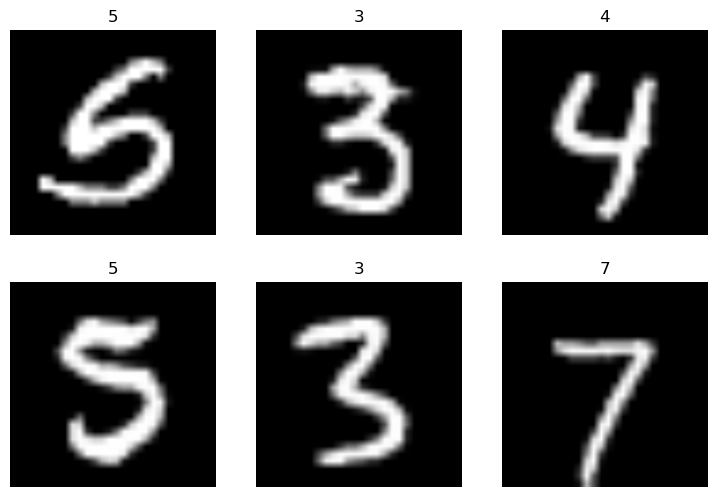

In [26]:
if do_learn:
    mnist1 = DataBlock(
        blocks=(ImageBlock, CategoryBlock), 
        get_items=get_image_files, 
        splitter=RandomSplitter(valid_pct=0.2, seed=42),
        get_y=parent_label,
        item_tfms=[Resize(192, method='squish')]
    )
    dls = mnist1.dataloaders(path, bs=32, device=default_device())
    dls.show_batch(max_n=6)

In [27]:
if do_learn:
    learn = vision_learner(dls, resnet18, metrics=error_rate)
    learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,0.178443,0.090630,0.026333,02:05


epoch,train_loss,valid_loss,error_rate,time
0,0.055780,0.043072,0.011167,02:54
1,0.035261,0.028618,0.007667,02:49
2,0.006978,0.023901,0.005500,02:48


In [11]:
if do_learn:
    learn.export()

In [12]:
if do_learn == False:
    learn = load_learner('export.pkl')

Independent on how the variable `do_learn` was set, we always have a learner now.

## Benchmarking

To get a feeling for whether or not a MacBook can be a valid replacement for a hosted GPU service, let's compare to the previous results:

### Apple Silicon (M2 Max)

![](apple-silicon-jl.png)

Interestingly, running it in VS Code is somewhat slower than in Jupyter Labs:

![](apple-silicon-vs.png)

Adding additional computation by adding the squish method added only some additional cost in terms of compute time, but much better training results:

![](apple-silicon-jl-squish.png)



### Microsoft Surface 4 Pro (as of November 2022)

Running the training on my local machine took about 40 minutes:

![CPU](benchmark-cpu.png)

### Paperspace (as of November 2022)

Running on a free Paperspace GPU-server took about 5 minutes:

![GPU](benchmark-free-gpu.png)